In [18]:
#imports 
import pandas 
import pickle 
import pickle5
#import format_data 
import itertools
from collections import Counter 
import pandas as pd
import random
#import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt

#from sklearn.metrics import roc_auc_score, roc_curve

In [22]:
#functions 
def cutoff_youdens_j(fpr,tpr,thresholds):
    """
    Calculate Youdens J for selecting the optimal threshold for predictions 
    
    :param fpr: false positive rate 
    :param tpr: true positive rate 
    :param thresholds: thresholds used for calculating true positives and false positives 
    :return: Youdens index (integer value) 
    """ 
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

def get_predictions(encodings, features, model, num_functions, n_features, max_length):
    """ 
    For a set of encoded prophages, maska single a gene and predict its function. 
    
    :param encodings: Prophages encoded as integer encoding of each gene 
    :param features: Features corresponding to each prophage 
    :param model: LSTM model to use for predictions 
    :param num_functions: Number of possible functions used in encoding 
    :param n_features: Number of features to use in encoding 
    :param max_length: cutoff for the maximum number of genes in a prophage 
    :return: the probabilities of each predictions, the predicted cateogory of each prediction, one-vs-rest category predictions, and one-vs-rest proability predictions  
    """
    
    prob_list = [[] for i in range(num_functions - 1)] 
    cat_list = [[] for i in range(num_functions - 1)]

    all_prob_list = []  
    all_cat_list = [] 

    for i in range(len(encodings)): 

        idx = random.randint(1, len(encodings[i]) -1) #don't include ends

        #make sure that the mask is not an uknown category 
        while encodings[i][idx] == 0: 
            idx = random.randint(1, len(encodings[i]) -1)

        X, y = format_data.generate_example(encodings[i], features[i], num_functions, n_features, max_length, idx) 
        yhat = model.predict(X, verbose = 0) 

        correct_category = np.argmax(y[0][idx])

        cat_list[correct_category-1].append(1) 
        prob_list[correct_category-1].append(yhat[0][idx][correct_category]) 

        #add the 'rest' 
        cat_list[correct_category - 1].append(0) 
        prob_list[correct_category - 1].append(1 - yhat[0][idx][correct_category]) 

        #append to all lists 
        all_prob_list.append(yhat[0][idx])  #needs to be from one onwards otherwise includes probability of being predicted to be unknown 
        all_cat_list.append(correct_category)
    
        return all_prob_list, all_cat_list, cat_list, prob_list
    
def calculate_thresholds(cat_list, prob_list, categories):
    """
    Calculate cutoff for each PHROG category using Youden's J
    
    :param cat_list: one-vs-rest category for a set of predictions 
    :param prob_list: one-vs-rest probability for a set of predictions 
    :param categories: keys: keys of the corresponding categories 
    :return: dictionary reporting Youden's J for each PHROG category 
    """
    
    thresholds = [] 
    
    for i in range(len(categories)):
        
        fpr, tpr, threshold = roc_curve(cat_list[i], prob_list[i])
        thresholds.append(cutoff_youdens_j(fpr, tpr, threshold)) 
        
    return dict(zip(categories, thresholds))


def calculate_category_AUC(cat_list, prob_list, categories): 
    """
    Calculate the AUC for each functional category. 
    
    :param cat_list: one-vs-rest category for a set of predictions 
    :param prob_list: one-vs-rest probability for a set of predictions 
    :param categories: keys: keys of the corresponding categories 
    :return: dictionary containing the Area Under the Curve (AUC) for each functional category 
    """ 
    aucs = [] 
    for i in range(len(categories)): 
        
        fpr, tpr, threshold = roc_curve(cat_list[i], prob_list[i])
        aucs.append(roc_auc_score(cat_list[i], prob_list[i])) 
        
    return dict(zip(categories, aucs))
    
def calculate_metrics(all_cat_list, all_prob_list, thresholds): 
    """
    Calculate the precision, recall and f1 score for a set of category predictions 
    
    :param all_cat_list: true category of a set of predictions
    :param all_prob_list: predicted softmax scores for a set of predictions 
    :param thresholds: thresholds to use for each cateogry as determined using Youden's index 
    :return: precision, recall, f1 score 
    """
    
    #create vectors to store true_positives, false positives, true negatives and false negatives 
    true_positive = np.zeros(num_functions - 1) 
    false_positive = np.zeros(num_functions - 1) 
    true_negative = np.zeros(num_functions - 1) 
    false_negative = np.zeros(num_functions - 1) 
    
    thresh_look = dict(zip([i for i in range(1,len(thresholds)+1)],thresholds.values()))
    thresh_look[0] = 1 #where model predicts unknown is unknown is not considered 

    for i in range(len(all_prob_list)):
       
        if np.max(all_prob_list[i]) > thresh_look.get(np.argmax(all_prob_list[i])):

            if all_cat_list[i] == np.argmax(all_prob_list[i]):

                true_positive[all_cat_list[i] -1] += 1 

            else:

                false_positive[np.argmax(all_prob_list[i])-1] += 1
                false_negative[all_cat_list[i] -1] += 1

        else:

            false_negative[all_cat_list[i] -1] += 1

    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative) 
    f1 = 2*precision*recall/(precision + recall) 
    
    return precision, recall, f1 

def error_margin(values): 
    """ 
    Get the margin of error, to be used for calculating confidence intervals 
    
    :param values: List of values to calculate margin of error for 
    :return: margin of error  
    """
    
    return np.std(values)/np.sqrt(len(values)) 
    
def plot_loss(history): 
    """ 
    Construct a plot comparing the loss and validation loss to evaluate tranining. 
    Prints the best validation loss and the file path of the model with the lowest validation loss
    
    :param history: list of the location of each of the history files
    """
    
    best_model = '' 
    best_loss = 1 

    for h in history: 
        file = open(h, 'rb') 
        h_dict = pickle5.load(file) 
        file.close() 

        plt.plot(h_dict[ 'loss' ][1:], color = 'blue')
        plt.plot(h_dict[ 'val_loss' ][1:], color = 'red')

        plt.xlabel( 'epoch' )
        plt.ylabel('loss') 
        plt.legend([ 'train' , 'validation' ], loc= 'upper right' )

        if np.min(h_dict[ 'val_loss' ][1:]) < best_loss: 
            best_loss = np.min(h_dict[ 'val_loss' ][1:])
            best_model = h 

    plt.show()
    print('best validation loss: ' + str(best_loss))
    print('best model:' + best_model)


In [ ]:
#generate dictionary 
annot = pd.read_csv('/home/grig0076/LSTMs/phrog_annot_v4.tsv', sep = '\t')

#hard-codedn dictionary matching the PHROG cateogories to an integer value 
one_letter = {'DNA, RNA and nucleotide metabolism' : 4,
     'connector' : 2,
     'head and packaging' : 3,
     'integration and excision': 1,
     'lysis' : 5,
     'moron, auxiliary metabolic gene and host takeover' : 6,
     'other' : 7,
     'tail' : 8,
     'transcription regulation' : 9,
     'unknown function' :  0}

#use this dictionary to generate an encoding of each phrog
phrog_encoding = dict(zip([str(i) for i in annot['phrog']], [one_letter.get(c) for c in annot['category']]))

#add a None object to this dictionary which is consist with the unknown 
phrog_encoding[None] = one_letter.get('unknown function')

In [162]:
#need to read in training genomes - manipulate such that we are reading in just some consistent set of training data 
file = open('/home/grig0076/phispy_phrog_pickles/cross_validated/prophage_phrog_data_derep_fourormore_lessthan121.pkl','rb')
all_data = pickle.load(file)
file.close()

all_encodings, all_features = format_data.format_data(all_data, phrog_encoding) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/grig0076/phispy_phrog_pickles/cross_validated/prophage_phrog_data_derep_fourormore_lessthan121.pkl'

How often does each cateogry appear? <br> 

The actual numbers of unique proteins in each category calculated using the checksums

In [39]:
category_counts = Counter(list(itertools.chain.from_iterable(all_encodings))) 
counts = [category_counts.get(one_letter.get(k)) for k in list(one_letter.keys())]
dict(zip(list(one_letter.keys()), counts))

{'DNA, RNA and nucleotide metabolism': 3552700,
 'connector': 1412603,
 'head and packaging': 3820238,
 'integration and excision': 1025968,
 'lysis': 1789606,
 'moron, auxiliary metabolic gene and host takeover': 1101890,
 'other': 1524623,
 'tail': 4552102,
 'transcription regulation': 2516063,
 'unknown function': 20780865}

### Compare models learning abilities 

In [15]:
base = '/home/grig0076/phispy_phrog_pickles/cross_validated/models/*' 
all_files = glob.glob(base + '*') 

history = [a for a in all_files if 'history.pkl' in a]
all_history = [h for h in history if 'all' in h]
strand_history = [h for h in history if 'strand' in h]
none_history = [h for h in history if 'none' in h]

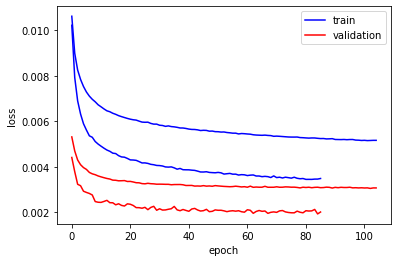

best validation loss: 0.0019259785767644644
best model:/home/grig0076/phispy_phrog_pickles/cross_validated/models/prophage_phrog_data_derep_fourormore_lessthan121_0_all_chunk_history.pkl


In [24]:
plot_loss(history)

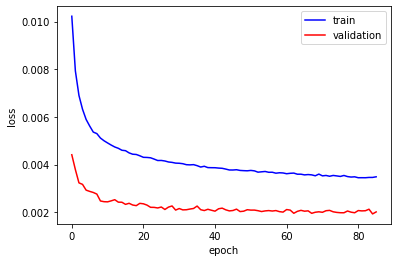

best validation loss: 0.0019259785767644644
best model:/home/grig0076/phispy_phrog_pickles/cross_validated/models/prophage_phrog_data_derep_fourormore_lessthan121_0_all_chunk_history.pkl


In [26]:
plot_loss(all_history)

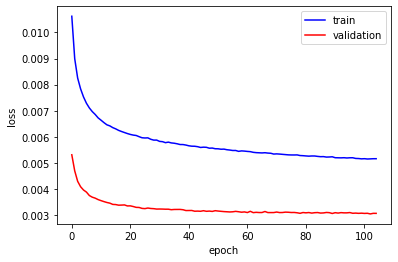

best validation loss: 0.003047205274924636
best model:/home/grig0076/phispy_phrog_pickles/cross_validated/models/prophage_phrog_data_derep_fourormore_lessthan121_0_none_chunk_history.pkl


In [27]:
plot_loss(none_history)

In [28]:
plot_loss(strand_history)

best validation loss: 1
best model:


### Plot ROC

All features

In [154]:
model_file = base + 'prophage_phrog_data_derep_fourormore_lessthan121_0_all_chunk_trained_LSTMbest_val_loss.h5' 
test_file = base  + 'prophage_phrog_data_derep_fourormore_lessthan121_test_chunk.pkl'

test_data = pickle.load(open(test_file, 'rb')) 
test_encodings, test_features = format_data.format_data(test_data, phrog_encoding)

model  = tf.keras.models.load_model(model_file)

num_functions = len(one_letter)
n_features = num_functions + len(test_features[0]) 
max_length = 120
categories = [dict(zip(list(one_letter.values()), list(one_letter.keys()))).get(i) for i in range(1,num_functions)]

plot curve

In [157]:
prob_list = [[] for i in range(num_functions - 1)] 
cat_list = [[] for i in range(num_functions - 1)]

all_prob_list = []  
all_cat_list = [] 

for i in range(3000): 
    
    idx = random.randint(1, len(test_encodings[i]) -1) #don't include ends
        
    #make sure that the mask is not an uknown category 
    while test_encodings[i][idx] == 0: 
        idx = random.randint(1, len(test_encodings[i]) -1)
    
    X, y = format_data.generate_example(test_encodings[i], test_features[i], num_functions, n_features, max_length, idx) 
    yhat = model.predict(X, verbose = 0) 
        
    #if [np.argmax(i) for i in yhat[0]][idx] == [np.argmax(i) for i in y[0]][idx]: 
    correct_category = np.argmax(y[0][idx])
    
    cat_list[correct_category-1].append(1) 
    prob_list[correct_category-1].append(yhat[0][idx][correct_category]) 
            
    #add the 'rest' 
    cat_list[correct_category - 1].append(0) 
    prob_list[correct_category - 1].append(1 - yhat[0][idx][correct_category]) 
    
    #append to all lists 
    all_prob_list.append(yhat[0][idx])  #needs to be from one onwards otherwise includes probability of being predicted to be unknown 
    all_cat_list.append(correct_category)

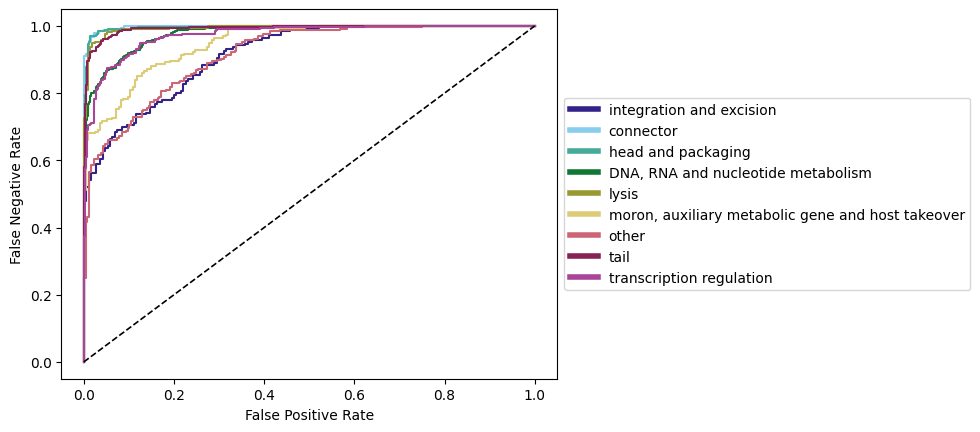

In [158]:
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"] 
categories = [dict(zip(list(one_letter.values()), list(one_letter.keys()))).get(i) for i in range(1,num_functions)]
threshold_list = []

for i in range(num_functions-1):
    fpr, tpr, threshold = roc_curve(cat_list[i], prob_list[i])
    plt.plot(fpr, tpr, color = colors[i], label = categories[i])
    
leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.plot([0, 1], [0, 1], color="black", lw=1.2, linestyle="--")

for line in leg.get_lines():
    line.set_linewidth(4.0)
    
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.show() 

Text(0, 0.5, 'False Negative Rate')

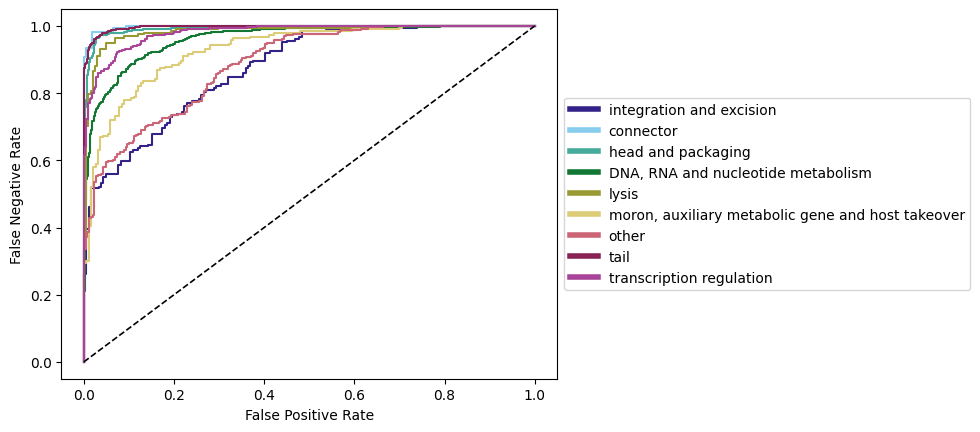

In [148]:
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"] 
categories = [dict(zip(list(one_letter.values()), list(one_letter.keys()))).get(i) for i in range(1,num_functions)]
threshold_list = []

for i in range(num_functions-1):
    fpr, tpr, threshold = roc_curve(cat_list[i], prob_list[i])
    plt.plot(fpr, tpr, color = colors[i], label = categories[i])
    
leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.plot([0, 1], [0, 1], color="black", lw=1.2, linestyle="--")

for line in leg.get_lines():
    line.set_linewidth(4.0)
    
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.show() 

Generate a dataframe from all of these scores 

In [98]:
thresholds = calculate_thresholds(cat_list, prob_list, categories)

In [159]:
calculate_category_AUC(cat_list, prob_list, categories)

{'integration and excision': 0.9151523545706371,
 'connector': 0.9977412166905772,
 'head and packaging': 0.9963005576457942,
 'DNA, RNA and nucleotide metabolism': 0.9781344307270233,
 'lysis': 0.9937782170211811,
 'moron, auxiliary metabolic gene and host takeover': 0.9489318737379104,
 'other': 0.9153507244621417,
 'tail': 0.9925149357932567,
 'transcription regulation': 0.9728851781255873}

In [160]:
precision, recall, f1 = caculate_metrics(all_cat_list, all_prob_list, thresholds) 

#temp plot - need to add confidence intervals

Text(0, 0.5, 'PHROG category')

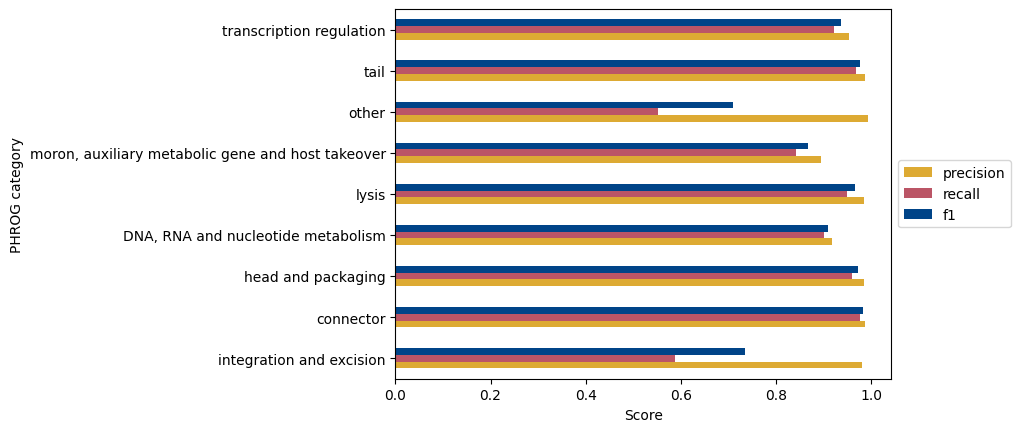

In [153]:
df = pd.DataFrame({'category': categories, 'precision': precision, 'recall': recall, 'f1': f1})

#add an average across the predictions - should this be weighted by category
#average_precision = np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_positive)) 
#average_recall =  np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_negative))
#average_f1 =  2*average_precision*average_recall/(average_precision + average_recall) 
#average_df = pd.DataFrame({'category': 'average', 'precision': average_precision, 'recall': average_recall, 'f1': average_f1},  index=[0])
#df = df.append(average_df)

ax = df.plot(kind='barh', color = ('#DDAA33', '#BB5566' , '#004488')) #alternative color blind friendly colours ('#66c2a5', '#fc8d62' , '#8da0cb') 
ax.set_yticklabels(df.category)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Score")
ax.set_ylabel("PHROG category")

Text(0, 0.5, 'PHROG category')

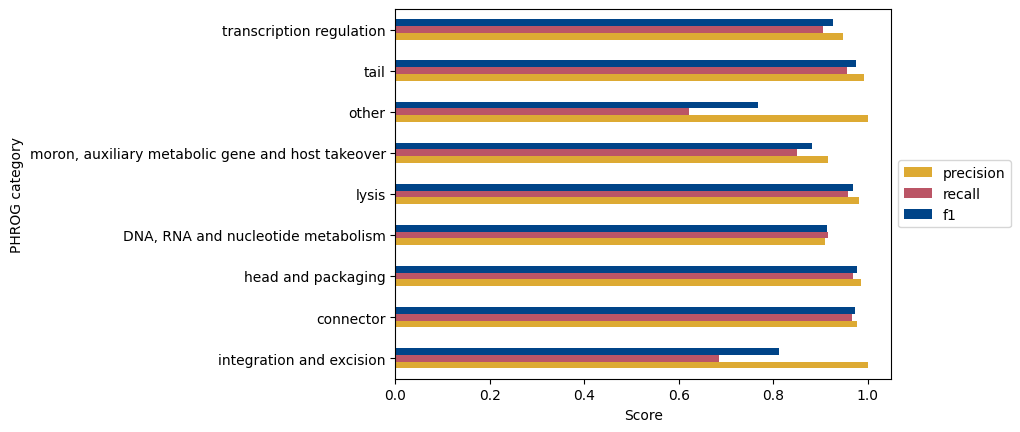

In [161]:
df = pd.DataFrame({'category': categories, 'precision': precision, 'recall': recall, 'f1': f1})

#add an average across the predictions - should this be weighted by category
#average_precision = np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_positive)) 
#average_recall =  np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_negative))
#average_f1 =  2*average_precision*average_recall/(average_precision + average_recall) 
#average_df = pd.DataFrame({'category': 'average', 'precision': average_precision, 'recall': average_recall, 'f1': average_f1},  index=[0])
#df = df.append(average_df)

ax = df.plot(kind='barh', color = ('#DDAA33', '#BB5566' , '#004488')) #alternative color blind friendly colours ('#66c2a5', '#fc8d62' , '#8da0cb') 
ax.set_yticklabels(df.category)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Score")
ax.set_ylabel("PHROG category")

In [ ]:
# 95% confidence interval 

1.95996 * error_estimate(values) 